## Práctica MLOps_LLMOps - MLFlow - Guillermo Barrio

Esta es la parte de la práctica dedicada a MLFlow, para la que hemos utilizado el dataset de airbnb, que ya fue utilizado a su vez en la prácita del módulo de Machine Learning.

En la parte de MLFlow específicamente, he sacado copias de pantalla de la GUI, que se adjuntan en un fichero adjunto PDF.

Comenzamos cargando las librerías necesarias.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn import preprocessing

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [25]:
import mlflow
import mlflow.sklearn

La práctica de ML se basaba en un fichero enorme (56 MB) que habia que limpiar de columnas que eran inútiles, todo ello antes de hacer la división train/test. He adjuntado solo los datsets posteriores a esa división, pero anteriores al preprocesado propiamente dicho. Los cargamos.

In [5]:
airbnb_train = pd.read_csv('airbnb_train.csv', sep=';', decimal='.')
airbnb_test = pd.read_csv('airbnb_test.csv', sep=';', decimal='.')

El preprocesado en sí incluía muchas acciones, que resumiremos en una sola celda, pero antes hay que definir una serie de funciones y listas de columnas, que se adjuntan a continuación.

In [6]:
fill_mode = ['Host Total Listings Count', 'Bathrooms', 'Bedrooms', 'Beds']

fill_mean = ['Host Response Rate',
             'Cleaning Fee',
             'Review Scores Rating',
             'Review Scores Accuracy',
             'Review Scores Cleanliness',
             'Review Scores Checkin',
             'Review Scores Communication',
             'Review Scores Location',
             'Review Scores Value',
             'Reviews per Month']

date_change = ['Host Since', 'First Review', 'Last Review']

objects_null = ['Host Since', 'Host Response Time', 'District', 'Room Type',
                'Amenities',
                'First Review',
                'Last Review',
                'Zipcode',
                'Neighbourhood',
                'Host Verifications',
                'Features',
                'Property Type',
                'Bed Type',
                'Calendar Updated',
                'Cancellation Policy']

categorical = ['Host Since', 'Host Response Time', 'District', 'Room Type',
                'Amenities',
                'First Review',
                'Last Review',
                'Zipcode',
                'Neighbourhood',
                'Host Verifications',
                'Features',
                'Property Type',
                'Bed Type',
                'Calendar Updated',
                'Cancellation Policy']

minimo = 10

cols_less_minimo = ['Host Since', 'Host Response Time', 'District', 'Room Type',
                    'Amenities',
                'First Review',
                'Last Review',
                'Zipcode',
                'Neighbourhood',
                'Host Verifications',
                'Features',
                'Property Type',
                'Bed Type',
                'Calendar Updated',
                'Cancellation Policy']

dict_more_minimo = {}

for col in cols_less_minimo:
    s = airbnb_train[col].value_counts()
    dict_more_minimo[col] = (s[s>minimo].index).to_list()


def check_minimo (x, col):

    if (x != 'Desconocido') and (x not in dict_more_minimo[col]):
      x = 'Otros'

    return x



In [8]:
Lat_avg = airbnb_train['Latitude'].mean()
Long_avg = airbnb_train['Longitude'].mean()

Ahora pasamos al preprocesado, que aplicamos al dataset de train. Incluimos eliminación de outliers y de columnas que no son útiles, imputamos valores a columnas con NA, transformamos columnas de fechas, encoding de columnas string, y demás.

In [9]:
airbnb_train = pd.read_csv('airbnb_train.csv', sep=';', decimal='.')

# Eliminación de outliers
airbnb_train = airbnb_train.loc[airbnb_train['Extra People'] < 50]
airbnb_train = airbnb_train.loc[airbnb_train['Minimum Nights'] < 100]
airbnb_train = airbnb_train.loc[airbnb_train['Maximum Nights'] < 1200]
airbnb_train = airbnb_train.loc[airbnb_train['Price'] < 400]

# Eliminación de algunas columnas
airbnb_train = airbnb_train.drop(['Host Listings Count', 'Weekly Price', 'Monthly Price', 'Security Deposit'], axis=1)

# Imputación en columnas numéricas
for col in fill_mode:
    airbnb_train[col].fillna(airbnb_train[col].mode()[0], inplace=True)

for col in fill_mean:
    airbnb_train[col].fillna(airbnb_train[col].mean(), inplace=True)

# Transformación de columnas de fechas
for col in date_change:
    airbnb_train[col] = airbnb_train[col].str[0:7]

# Imputación en columnas string
for col in objects_null:
    airbnb_train[col].fillna('Desconocido', inplace=True)

# Agrupación de registros poco comunes en columnas string
for col in cols_less_minimo:
    airbnb_train[col] = airbnb_train[col].apply(check_minimo, args = [col])

# Encoding columnas string
mean_map = {}
for c in categorical:
    mean = airbnb_train.groupby(c)['Price'].mean()
    airbnb_train[c] = airbnb_train[c].map(mean)
    mean_map[c] = mean

# Definición de nuevas columnas
airbnb_train['Distance_Center'] = ( (airbnb_train['Latitude'] - Lat_avg)**2 + (airbnb_train['Longitude'] - Long_avg)**2 ) ** (0.5)



Vemos que contamos con 44 columnas, incluyendo la target, que es el precio de la habitación (Price). En train contamos con 10.442 filas.

In [10]:
airbnb_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10442 entries, 0 to 10585
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      10442 non-null  float64
 1   Host Response Time              10442 non-null  float64
 2   Host Response Rate              10442 non-null  float64
 3   Host Total Listings Count       10442 non-null  float64
 4   Host Verifications              10442 non-null  float64
 5   Neighbourhood                   10442 non-null  float64
 6   District                        10442 non-null  float64
 7   Zipcode                         10442 non-null  float64
 8   Latitude                        10442 non-null  float64
 9   Longitude                       10442 non-null  float64
 10  Property Type                   10442 non-null  float64
 11  Room Type                       10442 non-null  float64
 12  Accommodates                    10442

Vemos, aplicando describe(), que no hay valores missing.

In [11]:
airbnb_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Since,10442.0,63.552385,0.173246,53.333333,63.555321,63.555321,63.555321,63.555321
Host Response Time,10442.0,63.552385,3.863242,55.822706,65.250942,65.780866,65.780866,67.677570
Host Response Rate,10442.0,94.867737,14.227047,0.000000,94.867737,100.000000,100.000000,100.000000
Host Total Listings Count,10442.0,9.759242,27.621265,0.000000,1.000000,2.000000,5.000000,265.000000
Host Verifications,10442.0,63.552385,8.682242,32.314286,59.594595,61.474427,69.751661,121.277778
Neighbourhood,10442.0,63.552385,16.722568,21.625000,52.758621,63.880952,76.664685,114.136986
District,10442.0,63.552385,12.918032,32.323944,52.290323,70.872652,70.872652,81.222714
Zipcode,10442.0,63.552385,14.574089,26.741935,59.064748,65.382952,70.980797,108.194118
Latitude,10442.0,40.420572,0.020232,40.332908,40.410058,40.418626,40.427885,40.514247
Longitude,10442.0,-3.696953,0.023603,-3.835498,-3.707675,-3.701573,-3.693656,-3.573613


Naturalmente, hay que aplicar exactamente los mismos procedimientos en el mismo orden al dataset de test, y eso es lo que hacemos.

In [14]:
airbnb_test = pd.read_csv('airbnb_test.csv', sep=';', decimal='.')

airbnb_test = airbnb_test.loc[airbnb_test['Extra People'] < 50]
airbnb_test = airbnb_test.loc[airbnb_test['Minimum Nights'] < 100]
airbnb_test = airbnb_test.loc[airbnb_test['Maximum Nights'] < 1200]
airbnb_test = airbnb_test.loc[airbnb_test['Price'] < 400]

airbnb_test = airbnb_test.drop(['Host Listings Count', 'Weekly Price', 'Monthly Price', 'Security Deposit'], axis=1)


for col in fill_mode:
    airbnb_test[col].fillna(airbnb_train[col].mode()[0], inplace=True)

for col in fill_mean:
    airbnb_test[col].fillna(airbnb_train[col].mean(), inplace=True)


for col in date_change:
    airbnb_test[col] = airbnb_test[col].str[0:7]


for col in objects_null:
    airbnb_test[col].fillna('Desconocido', inplace=True)


for col in cols_less_minimo:
    airbnb_test[col] = airbnb_test[col].apply(check_minimo, args = [col])


for c in categorical:
  airbnb_test[c] = airbnb_test[c].map(mean_map[c])


airbnb_test['Distance_Center'] = ( (airbnb_test['Latitude'] - Lat_avg)**2 + (airbnb_test['Longitude'] - Long_avg)**2 ) ** (0.5)





In [15]:
airbnb_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2604 entries, 1 to 2646
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      2604 non-null   float64
 1   Host Response Time              2604 non-null   float64
 2   Host Response Rate              2604 non-null   float64
 3   Host Total Listings Count       2604 non-null   float64
 4   Host Verifications              2604 non-null   float64
 5   Neighbourhood                   2604 non-null   float64
 6   District                        2604 non-null   float64
 7   Zipcode                         2604 non-null   float64
 8   Latitude                        2604 non-null   float64
 9   Longitude                       2604 non-null   float64
 10  Property Type                   2604 non-null   float64
 11  Room Type                       2604 non-null   float64
 12  Accommodates                    2604 no

Mostramos un histograma de la columna target, 'Price', cuya media es 64 euros, aunque hay habitaciones de más de 200 euros.

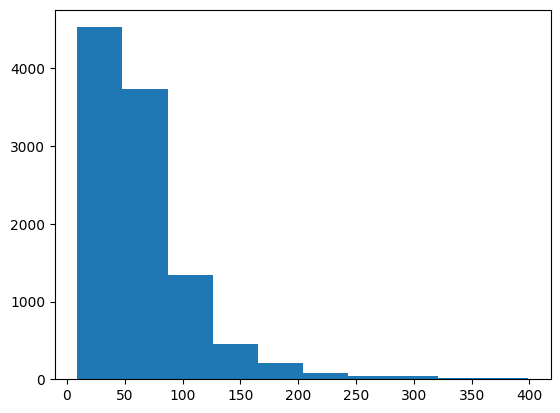

In [98]:
plt.hist(airbnb_train['Price'], bins = 10 )
plt.show()

Como decíamos en la práctica de ML, podemos pintar los gráficos scatter de cada columna con respecto al columna objetivo 'Precio'. En el caso de las antiguas columnas categóricas hemos perdido algo de perspectiva.

En el caso de los 'Bedrooms' vemos una cierta tendencia creciente con el precio, aunque hay excepciones. Algo parecido ocurre en el caso de los baños. Aquí puede influir también dónde esté situado el piso.

Es curioso que los pisos más caros se concentran hacia el centro de gravedad que hemos visto anteriormente, mientras que en el número de reviews, cuanto más existen, menor parece la varianza de precios.

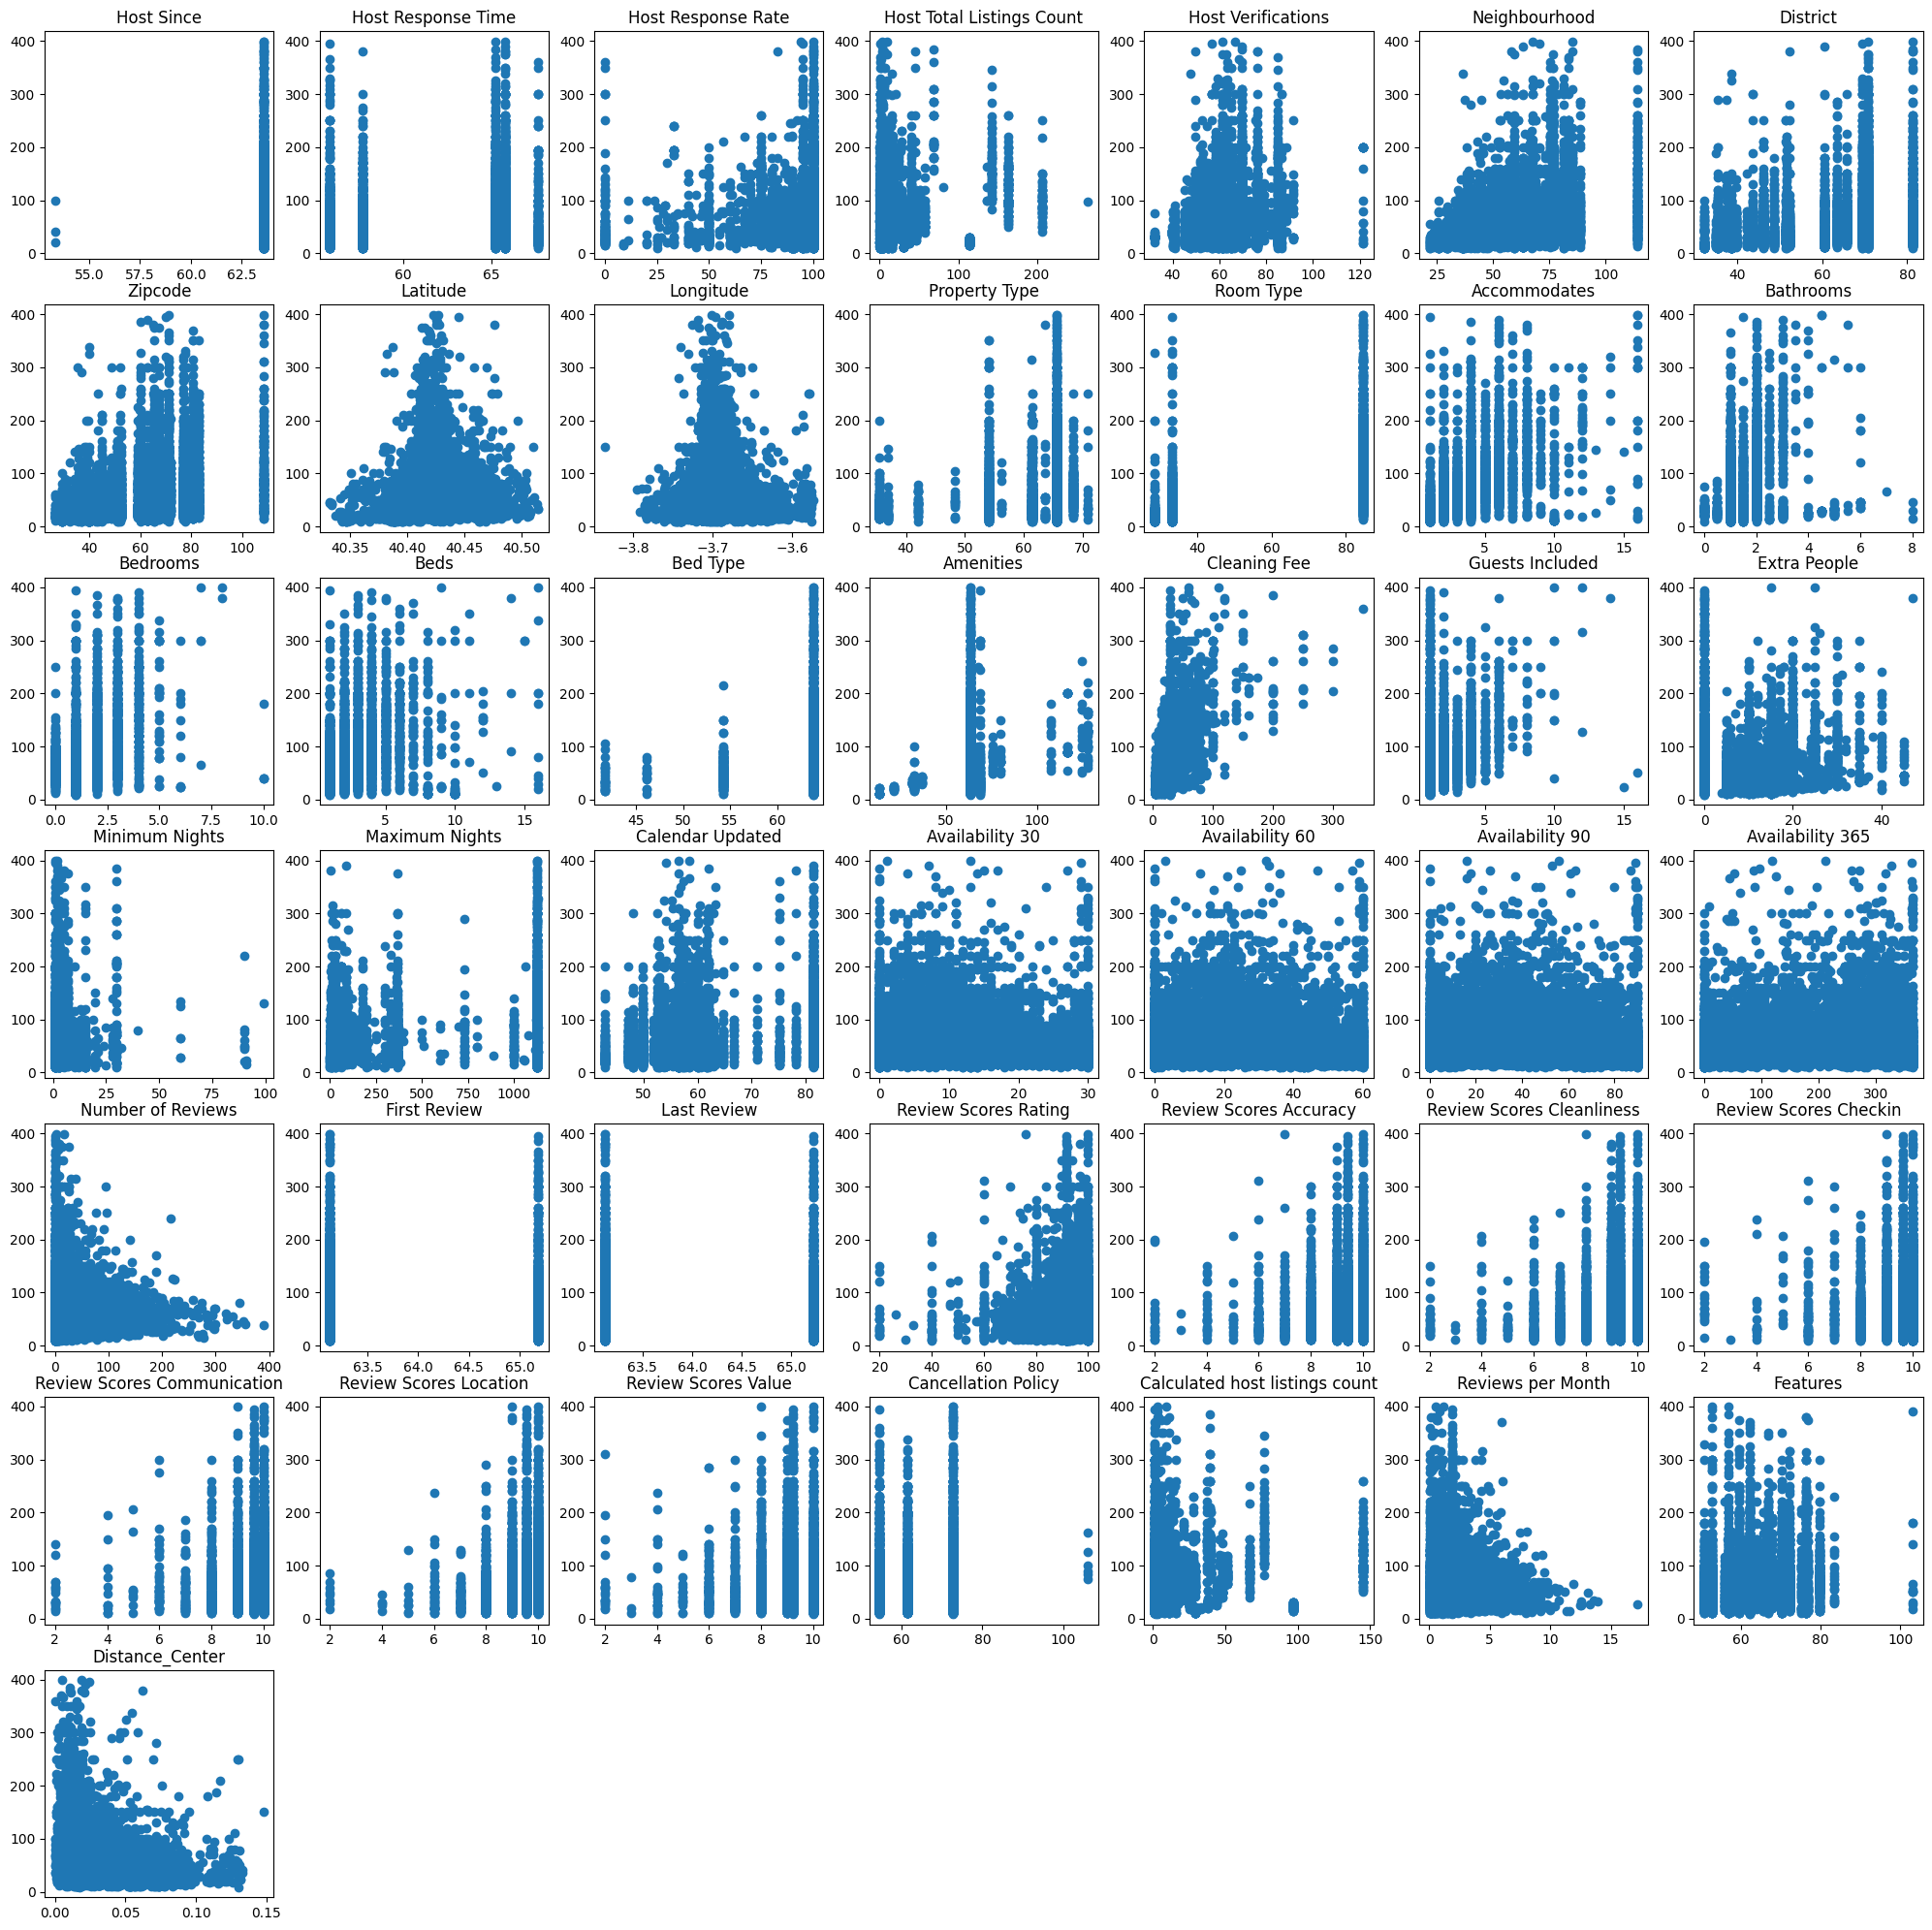

In [16]:
# Pintamos el histogramas para cada columna
plt.figure(figsize=(25,25))

for i,feature in enumerate(airbnb_train.columns.drop(['Price'])):
    plt.subplot(7,7,i+1)
    plt.scatter(airbnb_train[feature], airbnb_train['Price'] )
    plt.title(feature)

plt.show()

Podemos mostrar también los histogramas de cada columna, algunas de ellas bastante sesgadas, especialmente las de los reviews, que parecen ser notas de 0 a 10, y que en casi todos los casos la nota está entre 9 y 10.

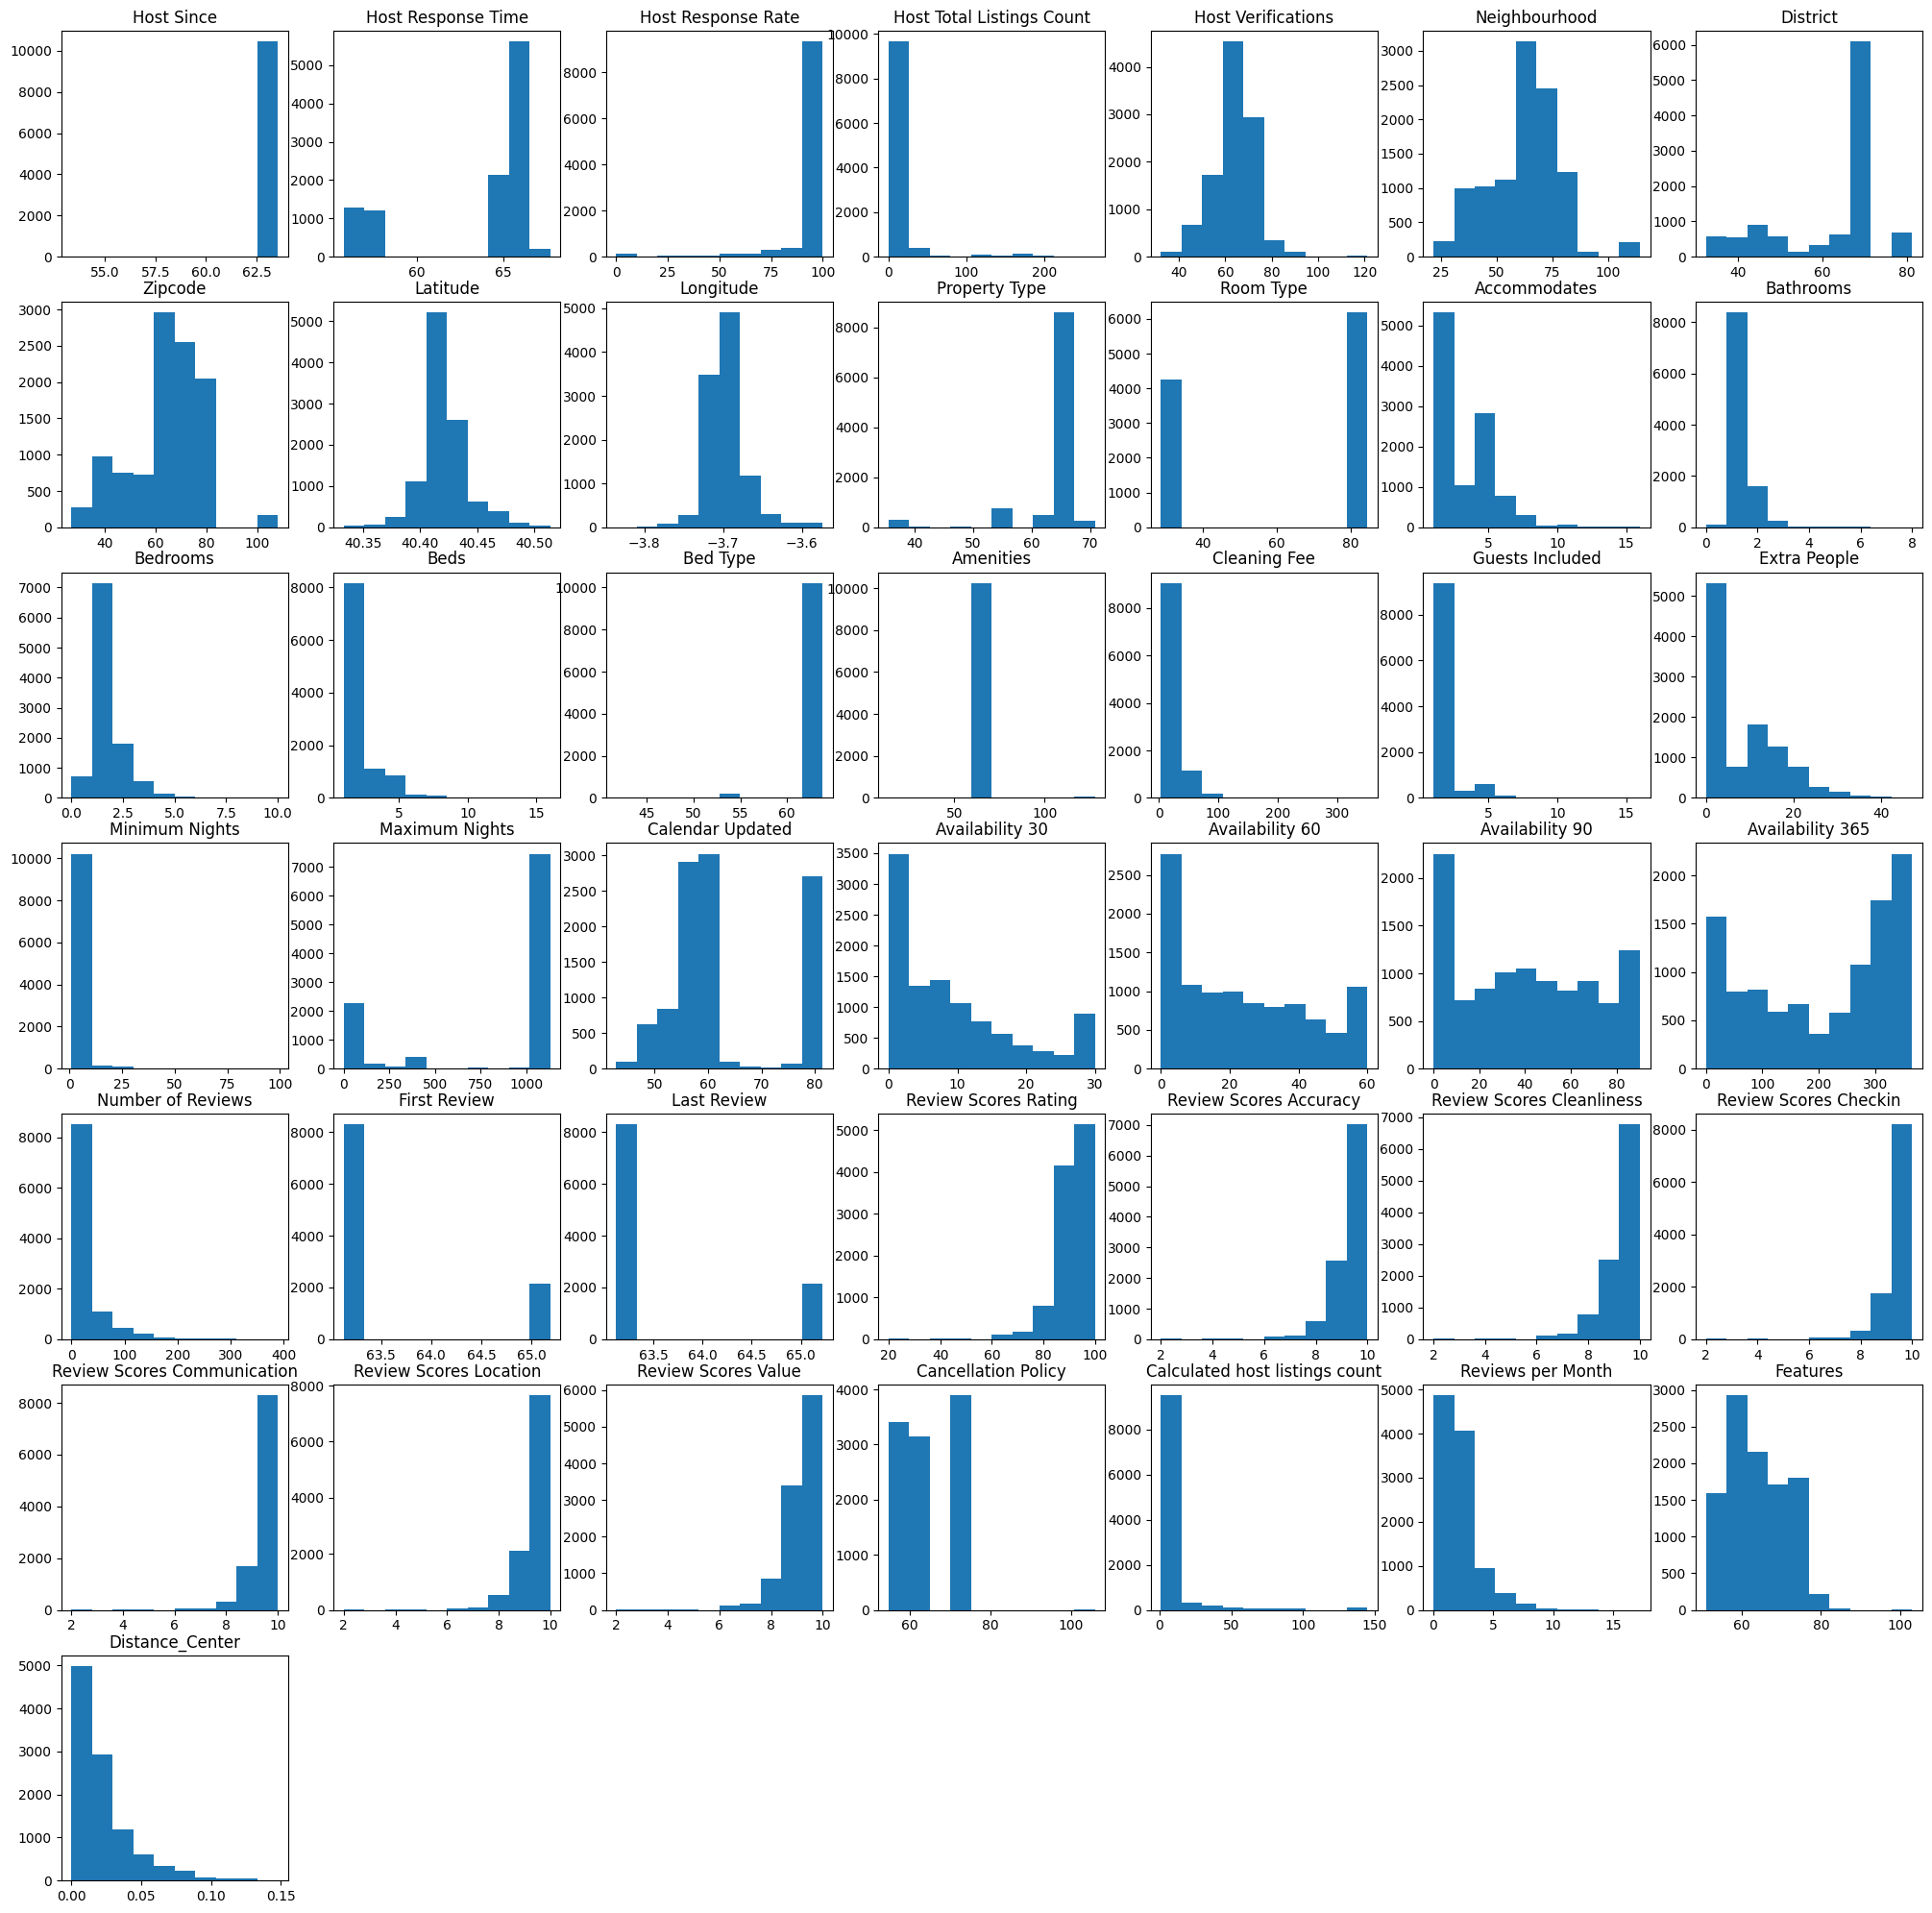

In [17]:
# Pintamos de nuevo histogramas para cada clase
plt.figure(figsize=(25,25))

for i,feature in enumerate(airbnb_train.columns.drop(['Price'])):
    plt.subplot(7,7,i+1)
    plt.hist(airbnb_train[feature])
    plt.title(feature)

plt.show()

Podemos echar un primer vistazo a la importancia de las columnas mediante f_regression y mutual_info_regression. Las limitaciones de ambos métodos son conocidas, pero nos pueden dar una ligera idea.

Encontramos que, comocabía esperar, el número de bedrooms y bathrooms tienen una cierta importancia, así como los guest included. Quizás la única sorpresa es la importancia alta del 'cleaning fee'.

Utilizaremos estos datos para, muy aproximadamente, seleccionar columnas más adelante.

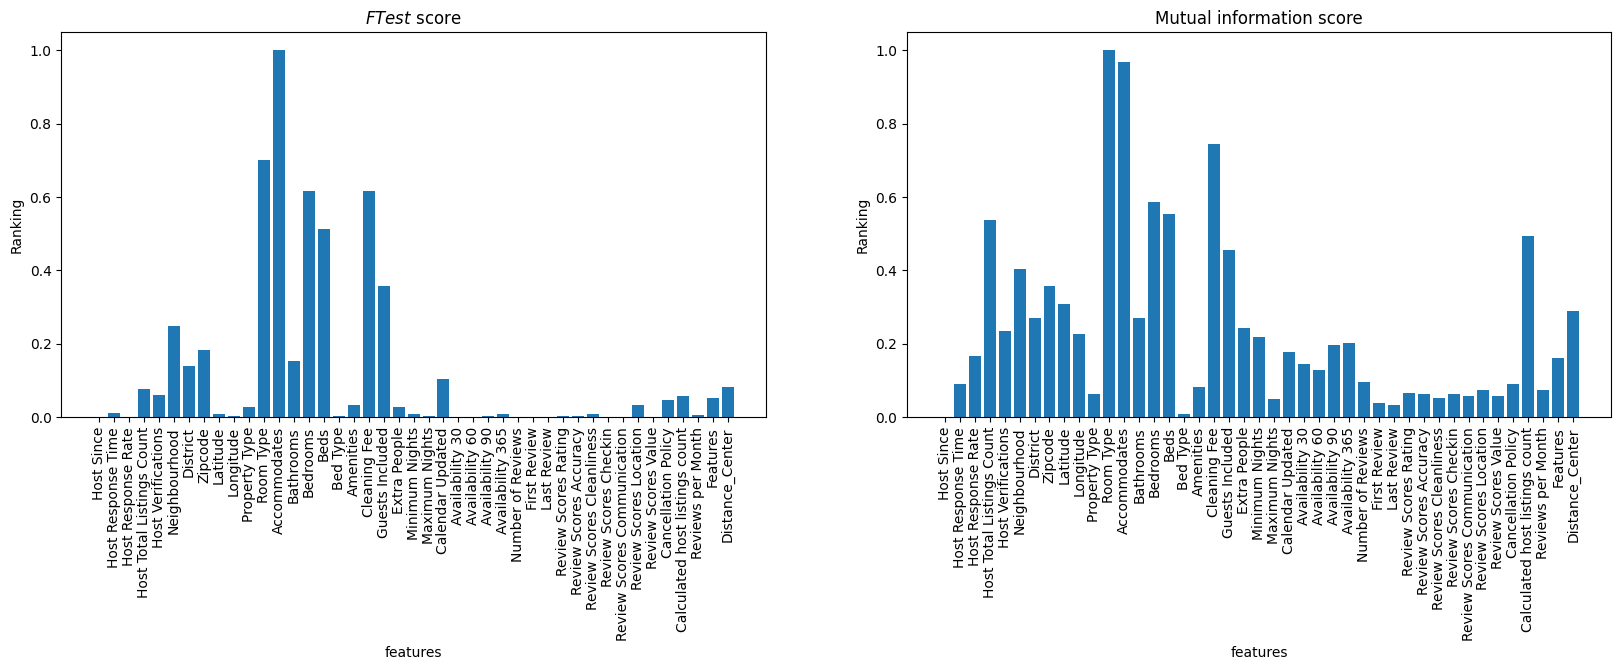

In [18]:
from sklearn.feature_selection import f_regression, mutual_info_regression

# convertimos el DataFrame al formato necesario para scikit-learn
# data = house_data.values

X_price = airbnb_train.drop(['Price'], axis=1)

y = airbnb_train['Price'].values     # nos quedamos con la 1ª columna, price
X = X_price.values    # nos quedamos con el resto

feature_names_mi = X_price.columns

# estudiamos los dos métodos de filtrado
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# visualización
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names_mi, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names_mi, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Separamos la columna target 'Price' tanto de train como test.

In [19]:
X_train = airbnb_train.drop(['Price'], axis=1).values
y_train = airbnb_train['Price'].values

X_test = airbnb_test.drop(['Price'], axis=1).values
y_test = airbnb_test['Price'].values

Ahora escalamos tanto train como test. No es estrictamente necesario hacerlo en Random Forest, que será el algoritmo que usemos a continuación, pero es una buena costumbre. En la práctica de ML, si que usamos algorítmos que requerian escalado, como SVM.

In [20]:
from sklearn import preprocessing

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test)

Repasamos la columna target, que indica una std de 46, por lo que el RMSE que obtengamos de los modelos más vale que se sitúe por debajo de ese nivel.

In [21]:
airbnb_train['Price'].describe()

count    10442.000000
mean        63.552385
std         46.330467
min          9.000000
25%         30.000000
50%         50.500000
75%         80.000000
max        399.000000
Name: Price, dtype: float64

Modelizamos el modelo de Random Forest en regresión, usando GridSearch para encontrar la profundidad óptima.

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.4s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=3; total time=   0.5s
[CV] END .......................................

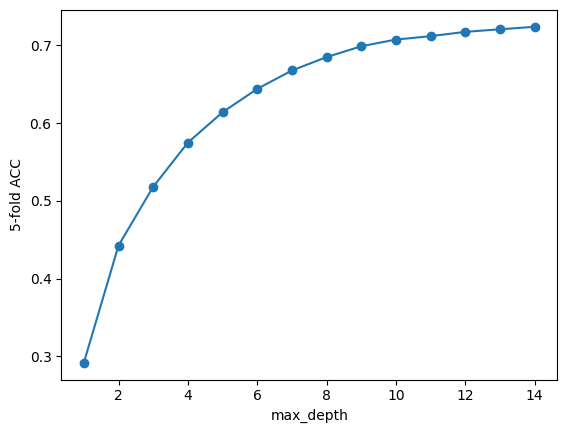

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=150, max_features='sqrt'), param_grid=tuned_parameters,cv=5, verbose=2)
grid.fit(XtrainScaled, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('5-fold R2')

plt.show()

Encontramos que la profundidad óptima es 14, pero vemos que tenemos overfitting.

In [24]:
maxDepthOptimo = grid.best_params_['max_depth']

# maxDepthOptimo = 9

randomForest = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators = 150,max_features='sqrt').fit(XtrainScaled,y_train)

print("Train: ",randomForest.score(XtrainScaled,y_train))
print("Test: ",randomForest.score(XtestScaled,y_test))

Train:  0.9186133620021445
Test:  0.7324416662273034


Es mejor elegir una profundidad menor, pongamos 9, que baja el R2, pero al menos reduce bastante el overfitting.

In [26]:
# maxDepthOptimo = grid.best_params_['max_depth']

maxDepthOptimo = 9

randomForest = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators = 150,max_features='sqrt').fit(XtrainScaled,y_train)

print("Train: ",randomForest.score(XtrainScaled,y_train))
print("Test: ",randomForest.score(XtestScaled,y_test))

Train:  0.8004859757482525
Test:  0.7128552042375402


Vemos que el RMSE en test es de 24, la mitad que la std de la columna target (46), por lo que en general, tenemos un buen modelo.

In [27]:
ytrainRF = randomForest.predict(XtrainScaled)
ytestRF  = randomForest.predict(XtestScaled)
mseTrainModelRF = mean_squared_error(y_train, ytrainRF)
mseTestModelRF = mean_squared_error(y_test, ytestRF)

print('MSE Modelo RF (train): %0.3g' % mseTrainModelRF)
print('MSE Modelo RF (test) : %0.3g' % mseTestModelRF)

print('RMSE Modelo RF (train): %0.3g' % np.sqrt(mseTrainModelRF))
print('RMSE Modelo RF (test) : %0.3g' % np.sqrt(mseTestModelRF))

MSE Modelo RF (train): 428
MSE Modelo RF (test) : 602
RMSE Modelo RF (train): 20.7
RMSE Modelo RF (test) : 24.5


## Utilización de MLFlow

Ahora pasamos a utilizar la librería de MLFlow. Hemos ido sacando copias de pantallas de los distintos pasos, que hemos incluido en el fichero PDF.

Iniciamos el proceso definiendo el experimento 'airbnb_RF'.

In [28]:
mlflow.set_experiment('airbnb_RF')

2026/01/30 10:30:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/01/30 10:30:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/01/30 10:30:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/01/30 10:30:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/01/30 10:30:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/01/30 10:30:19 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/01/30 10:30:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/30 10:30:19 INFO mlflow.store.db.utils: Updating database tables
2026/01/30 10:30:19 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/30 10:30:19 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/30 10:30:19 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/30 10:30:19 INFO alembic.runtime

<Experiment: artifact_location='file:///c:/Users/guill/KeepCoding_Bootcamp_IA/MLOps_LLMOps/Practica/mlruns/1', creation_time=1769765419763, experiment_id='1', last_update_time=1769765419763, lifecycle_stage='active', name='airbnb_RF', tags={}>

Inicialmente, definimos el modelo de RF con una profundidas cualquiera, en este caso 4, y calculamos las métricas de R2, RME y RMSE.

In [81]:
depth = 4

randomForest = RandomForestRegressor(max_depth=depth, n_estimators = 150, max_features='sqrt').fit(XtrainScaled,y_train)

ytestRF  = randomForest.predict(XtestScaled)

R2_score_test = round(randomForest.score(XtestScaled,y_test), 3)

print(R2_score_test)

mseTestModelRF = round(mean_squared_error(y_test, ytestRF), 1)

print(mseTestModelRF)

rmseTestModelRF = round(mean_squared_error(y_test, ytestRF)**(0.5), 1)

print(rmseTestModelRF)

# print("Train: ",randomForest.score(XtrainScaled,y_train))
# print("Test: ",randomForest.score(XtestScaled,y_test))

0.589
860.4
29.3


Tenemos un dataset de 43 columnas, siendo este uno de los parámetros que utilizaremos.

In [39]:
dims = X_train.shape[1]
dims

43

Primero utilizamos MLFlow para cargar los parametros del modelo de RF que hemos definido antes, aunque de momento no hemos subido el modelo como tal.

In [82]:
mlflow.set_experiment('airbnb_RF')
with mlflow.start_run(run_name='airbnb_prueba'):
    mlflow.log_metric('R2 train', R2_score_test)
    mlflow.log_metric('RMSE', rmseTestModelRF)
    mlflow.log_param('Depth', depth)
    mlflow.log_param('Dimension', dims)



Ahora definimos una función que nos dé, en función de la profundidad, el modelo de RF, así como el R2 y el RMSE, y que llamamos RF_metrics.

In [83]:
def RF_metrics(depth):

    randomForest = RandomForestRegressor(max_depth=depth, n_estimators = 150, max_features='sqrt').fit(XtrainScaled,y_train)

    R2_score_test = round(randomForest.score(XtestScaled,y_test), 3)

    ytestRF  = randomForest.predict(XtestScaled)

    # mseTestModelRF = round(mean_squared_error(y_test, ytestRF), 1)

    rmseTestModelRF = round(mean_squared_error(y_test, ytestRF)**(0.5), 1)

    return R2_score_test, rmseTestModelRF, randomForest

    

Probamos el caso de profundidad 5.

In [84]:
depth = 5

r2, rmse, model = RF_metrics(5)

In [85]:
r2

0.634

Ahora sí subimos el modelo, al que llamamos 'regressor', el run name en este caso es 'air_prueba_2'.

In [86]:
mlflow.set_experiment('airbnb_RF')
with mlflow.start_run(run_name='airbnb_prueba_2'):
    mlflow.log_metric('R2 test', r2)
    mlflow.log_metric('RMSE', rmse)
    mlflow.log_param('Depth', depth)
    mlflow.log_param('Dimension', dims)
    mlflow.sklearn.log_model(model, 'regressor')

2026/01/30 12:35:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Ahora haremos un bucle para crear varios runs, con distintas profundidades, en este caso de 3, 6, 9 y 12. También nos aseguramos que ponemos un nombre diferente a cada modelo.

In [87]:
depth_list = [3, 6, 9, 12]

In [ ]:
for depth in depth_list:
    n = 'regressor_'
    name = n + str(depth)
    print(name)

    

regressor_3
regressor_6
regressor_9
regressor_12


Ahora generamos un run con cada profundidad, y subimos métricas y parámetros. El parámetro dims es constante, 43. Los runs se llaman todos 'airbnb_RF'. 

In [89]:
for depth in depth_list:
    print(depth)
    r2, rmse, model = RF_metrics(depth)

    n = 'regressor_'
    name = n + str(depth)

    mlflow.set_experiment('airbnb_RF')
    with mlflow.start_run(run_name='airbnb_RF'):
       mlflow.log_metric('R2 test', r2)
       mlflow.log_metric('RMSE', rmse)
       mlflow.log_param('Depth', depth)
       mlflow.log_param('Dimension', dims)
       mlflow.sklearn.log_model(model, name)

3


2026/01/30 12:36:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


6


2026/01/30 12:36:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


9


2026/01/30 12:36:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


12


2026/01/30 12:36:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


En la GUI hacemos una comparación de las métricas en función de la profundidad, y se observa que a mayor profundidad el R2 sube y el RMSE baja, lo cual es lo que era de esperar.

En la GUI de MLFlow, registramos el modelo 'regressor_12' con un nombre que refleja las 43 columnas que hemos utilizado del dataset. Ahora en MLFLow tenemos que seleccionar un 'Alias', que definimos nosotros, ya que MLFlow ha deprecado el 'Stage' de Production o Archived. Elegimos el alias de 'preferred', y de esta manera lo cargamos de nuevo.

In [56]:
model_name = 'Regressor_12_depth_43_dims'

# models:/MyModel@champion

model_mlflow = mlflow.pyfunc.load_model(f'models:/{model_name}@preferred')

2026/01/30 11:58:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/30 11:58:45 INFO mlflow.store.db.utils: Updating database tables
2026/01/30 11:58:45 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/30 11:58:45 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Ahora podemos utilizar este modelo para, por ejemplo, estimar los precios de 10 filas.

In [63]:
preds = np.round(model_mlflow.predict(XtestScaled[0:10]), 0)

In [64]:
preds

array([54., 99., 36., 34., 60., 33., 84., 62., 31., 61.])

Desde luego, 43 columnas pueden resultar muchas, por lo que podemos seleccionar las que consideramos más importantes, como ya vimos anteriormente. En este caso seleccionamos 9 de ellas, tanto para train como test.

In [65]:
airbnb_train_RF = airbnb_train[['Bedrooms', 'Room Type', 'Accommodates', 'Cleaning Fee', 'Bathrooms', 'Beds', 'Neighbourhood', 'Guests Included', 'Zipcode']]

In [66]:
airbnb_test_RF = airbnb_test[['Bedrooms', 'Room Type', 'Accommodates', 'Cleaning Fee', 'Bathrooms', 'Beds', 'Neighbourhood', 'Guests Included', 'Zipcode']]

En principio en este caso no hemos estandarizado, ya que no es realmente necesario para el algoritmo de Random Forest. Aplicamos de nuevo GridSearch, y vemos que, en general, obtenemos R2 más bajos.

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=3; total time=   0.2s
[CV] END .......................................

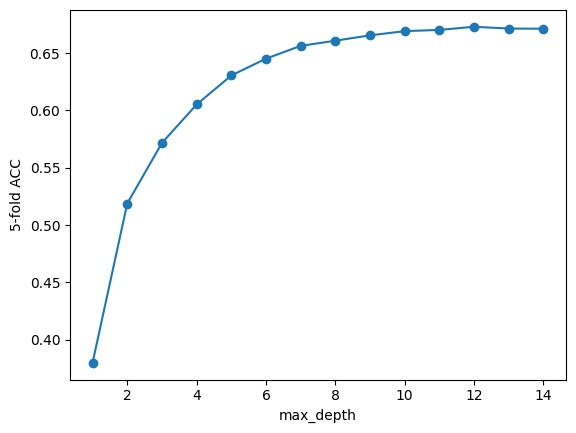

In [78]:
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=150, max_features='sqrt'), param_grid=tuned_parameters,cv=5, verbose=2)
grid.fit(airbnb_train_RF, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('5-fold ACC')

plt.show()

Para una profundidad de 9, el R2 es 0.69, frente a 0.71 anteriormente, con las 43 columnas, aunque para haber recortado a 9 columnas no está tan mal, teniendo en cuenta la simplificación que hemos actualizado.

In [79]:
maxDepthOptimo = 9

randomForest_simp = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators = 150,max_features='sqrt').fit(airbnb_train_RF, y_train)

print("Train: ",randomForest_simp.score(airbnb_train_RF, y_train))
print("Test: ",randomForest_simp.score(airbnb_test_RF,y_test))

Train:  0.751615200291242
Test:  0.688253810025452


Definimos la función de cálculo de las métricas, con los datasets simplificados.

In [96]:
def RF_metrics_simp(depth):

    randomForest = RandomForestRegressor(max_depth=depth, n_estimators = 150, max_features='sqrt').fit(airbnb_train_RF, y_train)

    R2_score_test = round(randomForest.score(airbnb_test_RF,y_test), 3)

    ytestRF  = randomForest.predict(airbnb_test_RF)

    # mseTestModelRF = round(mean_squared_error(y_test, ytestRF), 1)

    rmseTestModelRF = round(mean_squared_error(y_test, ytestRF)**(0.5), 1)

    return R2_score_test, rmseTestModelRF, randomForest

In [94]:
dims_simp = airbnb_train_RF.shape[1]
dims_simp

9

Ahora volvemos a hacer los runs, con las mismas profundidades de antes, pero ahora la dimensión de todas ellas es 9 y no 43.

En la GUI ahora comparamos las métricas de la produndidad 9 con dimensiones 43 y 9, que muestran que en el primer caso el R2 es superior y el RMSE es inferior, lo cual es lógico.

In [97]:
for depth in depth_list:
    print(depth)
    r2, rmse, model = RF_metrics_simp(depth)

    n = 'regressor_simp_'
    name = n + str(depth)

    mlflow.set_experiment('airbnb_RF')
    with mlflow.start_run(run_name='airbnb_RF_simp'):
       mlflow.log_metric('R2 test', r2)
       mlflow.log_metric('RMSE', rmse)
       mlflow.log_param('Depth', depth)
       mlflow.log_param('Dimension', dims_simp)
       mlflow.sklearn.log_model(model, name)

3


2026/01/30 12:45:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


6


2026/01/30 12:45:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


9


2026/01/30 12:45:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


12


2026/01/30 12:45:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
